In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image, ImageOps
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from skimage.feature import local_binary_pattern
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score, recall_score, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


### **Extracting LBP Features**

In [3]:
def compute_lbp(arr):
  # LBP function params
  radius = 3
  n_points = 8 * radius
  n_bins = n_points + 2
  lbp = local_binary_pattern(arr,n_points,radius,'uniform')
  lbp = lbp.ravel()
  #feature_len = int(lbp.max() + 1)
  feature = np.zeros(n_bins)
  for i in lbp:
    feature[int(i)] += 1 # Feature
  feature /= np.linalg.norm(feature, ord=1) # Normalizing feature
  return feature

### **Load Images and Get LBP Features**

In [4]:
image_dir = "/gdrive/My Drive/Project/Denoised_CLAHE_Cl3"

In [5]:
def load_data(tag='train'):
  tag_dir = os.path.join(image_dir, tag)
  tag_path = Path(tag_dir)
  data = [] # Images
  cat = [] # Category
  subcat = []
  patient = []
  file_name = []
  for mag_dir in tag_path.iterdir():  
    mag_label = mag_dir.stem
    print("*",mag_label)
    if mag_label == "100X":
      print("Got it!")
      for img_name in mag_dir.glob('*.png'):
        img_label = img_name.stem
        splitted_image_name = img_label.split('_')
        cat_label = splitted_image_name[1]
        remaining_part = splitted_image_name[2].split('-')
        subcat_label = remaining_part[0]
        patient_label = remaining_part[2]
        img = Image.open(img_name.as_posix()) # as_posix() returns the absolute path
        if img.mode != 'L':
          img = ImageOps.grayscale(img)
        arr = np.array(img) # convert the image to numpy array
        feature = compute_lbp(arr)
        data.append(feature) # append the feature to the data
        cat.append(cat_label) # append the label to the category
        subcat.append(subcat_label)
        patient.append(patient_label)
        file_name.append(img_label)
  return data, cat, subcat, patient, file_name

In [6]:
# train images
vec_train, cat_train, subcat_train, patient_train, image_name_train = load_data('train')
# test images
vec_test, cat_test, subcat_test, patient_test, image_name_test = load_data('test')

* 40X
* 100X
Got it!
* 200X
* 400X
* 40X
* 100X
Got it!
* 200X
* 400X


### **List the Categories**

In [7]:
# Get unique categories for train data
labels = list(np.unique(np.array(cat_train))) # convert categories to the numpy array and get unique values
labels

['B', 'M']

In [8]:
# Get unique categories for test data
labels = list(np.unique(np.array(cat_test)))
labels

['B', 'M']

### **Label Encoding**

In [9]:
le = LabelEncoder()
label_train = le.fit_transform(cat_train) # Here fit is used to assign 0 or 1
label_test = le.transform(cat_test) # Only transform is used since the fit is already done above

In [10]:
label_train

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
label_test

### **Function to Compute Patient Recognition Rate**

In [12]:
def evaluate_recognition_rate(pred):
  inverted_prediction = le.inverse_transform(prediction)
  unique_patient_test = list(np.unique(np.array(patient_test)))
  num_images_per_patient = []
  num_correctly_classified = []
  num = 0
  total_patient_score = 0
  num_patient = 0
  for patient in unique_patient_test:
    num_patient = num_patient + 1
    Np = 0
    Nrec = 0
    image_index_counter = -1
    for image_name in image_name_test:
      image_index_counter = image_index_counter + 1
      image_name_splitted = image_name.split('-')
      if patient == image_name_splitted[2]:
        first_part_splitted = image_name_splitted[0].split('_')
        image_class = first_part_splitted[1]
        if image_class == inverted_prediction[image_index_counter]:
          Nrec = Nrec + 1
        Np = Np + 1
    patient_score = Nrec/Np
    #print(patient_score)
    num_images_per_patient.append(Np)
    num_correctly_classified.append(Nrec)
    total_patient_score = total_patient_score + patient_score
    num = num + Np    
  recognition_rate = total_patient_score/num_patient
  print("Summation of patient score: ", total_patient_score)
  print("Total Number of Patients: ", num_patient)
  print("Recognition Rate: ", recognition_rate)

### **SVM Fit**

In [34]:
pipe1 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", SVC(probability=True, kernel = 'rbf', gamma = 0.01, C = 100)) #radial basis function kernel
                 ])

In [35]:
pipe1.fit(vec_train,label_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', SVC(C=100, gamma=0.01, probability=True))])

**Accuracy**

Accuracy: 79.61%


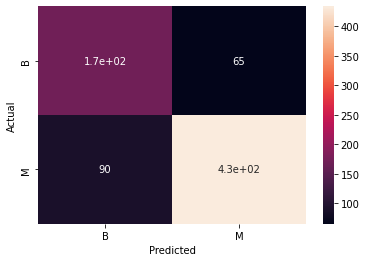

In [36]:
# Test set evaluation
prediction = pipe1.predict(vec_test)
# Visualization
cmat = metrics.confusion_matrix(prediction,label_test)
s = sns.heatmap(cmat,annot=True,xticklabels=labels, yticklabels=labels)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

**Area Under Curve**

In [37]:
prediction_prob = pipe1.predict_proba(vec_test)
print("Area under curve (AUC): ", roc_auc_score(label_test, prediction_prob[:,1]))

Area under curve (AUC):  0.85487449995777


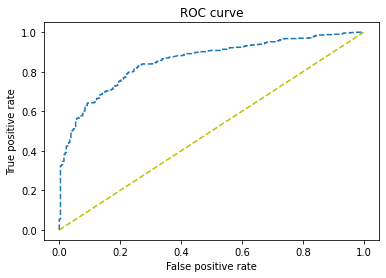

In [38]:
fpr, tpr, thresholds = roc_curve(label_test, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Patient Recognition Rate**

In [39]:
evaluate_recognition_rate(prediction)

Summation of patient score:  22.805050343335246
Total Number of Patients:  28
Recognition Rate:  0.8144660836905445


### **Random Forest**

In [53]:
pipe2 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", RandomForestClassifier(class_weight='balanced', n_estimators = 100, random_state = 42))
                 ])

In [54]:
pipe2.fit(vec_train, label_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

**Accuracy**

Accuracy: 72.24%


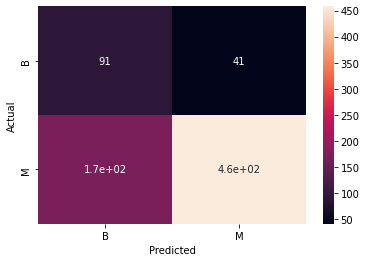

In [55]:
# Test set evaluation
prediction = pipe2.predict(vec_test)
# Visualization
cmat = confusion_matrix(prediction,label_test)
s = sns.heatmap(cmat,annot=True,xticklabels=labels, yticklabels=labels)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

**Area Under Curve**

In [56]:
prediction_prob = pipe2.predict_proba(vec_test)
print("Area under curve (AUC): ", roc_auc_score(label_test, prediction_prob[:,1]))

Area under curve (AUC):  0.7623446125968412


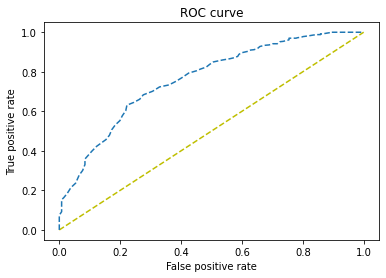

In [57]:
fpr, tpr, thresholds = roc_curve(label_test, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Patient Recognition Rate**

In [58]:
evaluate_recognition_rate(prediction)

Summation of patient score:  21.044929865864415
Total Number of Patients:  28
Recognition Rate:  0.7516046380665863


### **KNN**

In [76]:
pipe3 = Pipeline([
                 ("scale",StandardScaler()),
                 ("classifier", KNeighborsClassifier(n_neighbors=7))
                 ])

In [77]:
pipe3.fit(vec_train,label_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=7))])

**Accuracy**

Accuracy: 71.71%


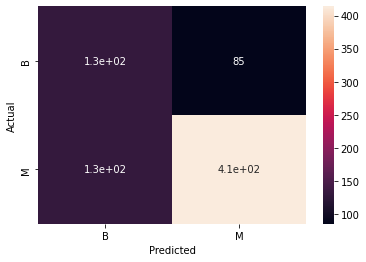

In [78]:
# Test set evaluation
prediction = pipe3.predict(vec_test)
# Visualization
cmat = confusion_matrix(prediction,label_test)
s = sns.heatmap(cmat,annot=True,xticklabels=labels, yticklabels=labels)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

**Area Under Curve**

In [79]:
prediction_prob = pipe3.predict_proba(vec_test)
print("Area under curve (AUC): ", roc_auc_score(label_test, prediction_prob[:,1]))

Area under curve (AUC):  0.7323574351768671


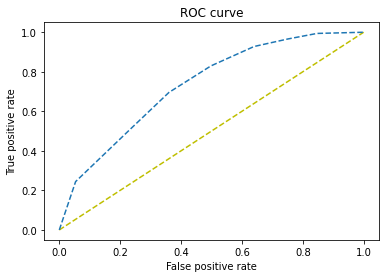

In [80]:
fpr, tpr, thresholds = roc_curve(label_test, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Patient Recognition Rate**

In [81]:
evaluate_recognition_rate(prediction)

Summation of patient score:  20.752542362695895
Total Number of Patients:  28
Recognition Rate:  0.741162227239139


### **AdaBoost**

In [84]:
clf = AdaBoostClassifier(n_estimators=100, random_state=42)
clf.fit(vec_train,label_train)

AdaBoostClassifier(n_estimators=100, random_state=42)

**Accuracy**

Accuracy: 68.95%


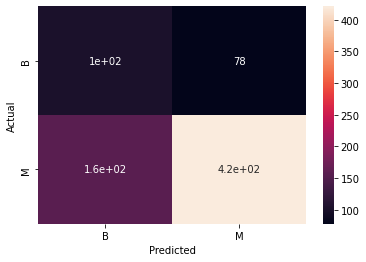

In [85]:
# Test set evaluation
prediction = clf.predict(vec_test)
# Visualization
cmat = confusion_matrix(prediction,label_test)
s = sns.heatmap(cmat,annot=True,xticklabels=labels, yticklabels=labels)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

**Area Under Curve**

In [86]:
prediction_prob = clf.predict_proba(vec_test)
print("Area under curve (AUC): ", roc_auc_score(label_test, prediction_prob[:,1]))

Area under curve (AUC):  0.707725796420427


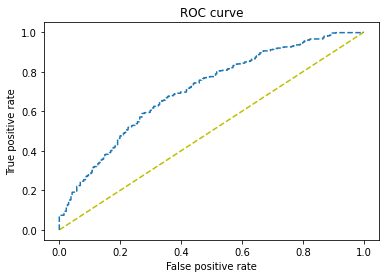

In [87]:
fpr, tpr, thresholds = roc_curve(label_test, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Patient Recognition Rate**

In [88]:
evaluate_recognition_rate(prediction)

Summation of patient score:  19.88131014798434
Total Number of Patients:  28
Recognition Rate:  0.7100467909994407


### **Xgboost**

In [99]:
"""
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)    
"""
mod1 = xgb.XGBClassifier(booster='dart')
vec_train_arr = np.array(vec_train)
vec_test_arr = np.array(vec_test)
mod1.fit(vec_train_arr, label_train)

XGBClassifier(booster='dart')

**Accuracy**

In [100]:
prediction = mod1.predict(vec_test_arr)
print("Accuracy = ", accuracy_score(label_test, prediction))

Accuracy =  0.7092105263157895


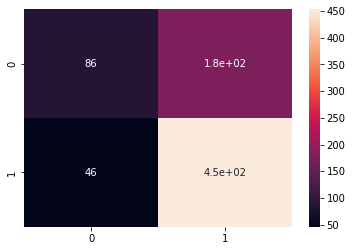

In [101]:
cm = confusion_matrix(label_test, prediction)
sns.heatmap(cm, annot=True)

**Area Under Curve**

In [102]:
prediction_prob = mod1.predict_proba(vec_test_arr)
print("Area under curve (AUC): ", roc_auc_score(label_test, prediction_prob[:,1]))

Area under curve (AUC):  0.7594345779681969


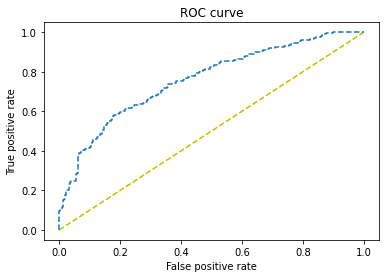

In [103]:
fpr, tpr, thresholds = roc_curve(label_test, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Patient Recognition Rate**

In [104]:
evaluate_recognition_rate(prediction)

Summation of patient score:  20.726498168399154
Total Number of Patients:  28
Recognition Rate:  0.7402320774428269


### **LightGBM**

In [105]:
scaler = StandardScaler()
vec_train_scaled = scaler.fit_transform(vec_train)
vec_test_scaled = scaler.transform(vec_test)
d_train = lgb.Dataset(vec_train_scaled, label=label_train)

In [106]:
lgbm_params = {'learning_rate':0.05, 'boosting_type':'gbdt', #Sometimes dart gives better accuracy. gbdt means gradient boosting.
              'objective':'binary',
              'metric':['auc', 'binary_logloss'],
              'num_leaves':100, # optimizing this avoids overfitting. 50 to 100
              'max_depth':10} #10 may be appropriate

In [108]:
clf = lgb.train(lgbm_params, d_train, 50) #50 iterations. Increase iterations for small learning rates. eg if learning grate = 0.005, we may need 500 iterations.
prediction=clf.predict(vec_test_scaled)
#convert the probabilities into binary values 0/1 for classification
for i in range(0, vec_test_scaled.shape[0]):
    if prediction[i]>=.5: # setting threshold to 0.5
       prediction[i]=1
    else:  
       prediction[i]=0

**Accuracy**

Accuracy =  0.7210526315789474


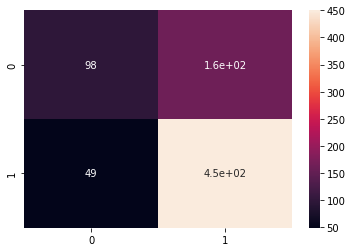

In [109]:
#Print accuracy
print ("Accuracy = ", accuracy_score(label_test, prediction))
#Confusion matrix
cm_lgbm = confusion_matrix(label_test, prediction)
sns.heatmap(cm_lgbm, annot=True)

**Area Under Curve**

In [110]:
prediction_prob=clf.predict(vec_test_scaled)
print("Area under curve (AUC): ", roc_auc_score(label_test, prediction_prob))

Area under curve (AUC):  0.7731938973732906


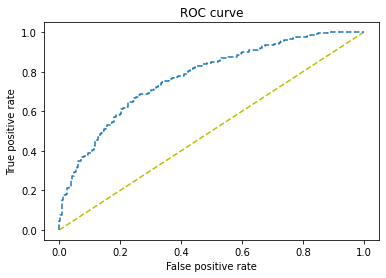

In [111]:
fpr, tpr, thresholds = roc_curve(label_test, prediction_prob) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Patient Recognition Rate**

In [112]:
prediction = prediction.astype(int)
evaluate_recognition_rate(prediction)

Summation of patient score:  20.86335085605354
Total Number of Patients:  28
Recognition Rate:  0.7451196734304836


### **Grid search to find the best model and parameters**

In [ ]:
skf = StratifiedKFold(n_splits = 5)

In [ ]:
# Defining a dictionary
model_params = {
    'svm': {
        'model': SVC(gamma='auto'),
        'params' : {
            'C': [0.1, 1, 5, 10, 100], #Regularization parameter.
            'kernel': ['rbf','linear','sigmoid','poly'], 
            'gamma':[0.00001,0.0001,0.001,0.01,0.1,1]
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [30,50,70,100] #Trees: may lead to overfitting if n_estimators is too much
        }
    },
    'KNN' : {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [1, 5, 9, 15, 19, 23, 27, 31, 35, 39]
        }
    }
}

In [ ]:
scores = []

for model_name, mp in model_params.items():
    grid =  GridSearchCV(estimator=mp['model'], 
                         param_grid=mp['params'], 
                         cv=skf, n_jobs=6, #five fold cross validation
                         return_train_score=False)
    
    grid.fit(vec_train,label_train)
    
    scores.append({
        'model': model_name,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_
    })

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])

print(df)